Hurst exponent , kauffman efficiency and ADF test

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
import seaborn as sn

In [3]:
from curl_cffi import requests

session = requests.Session(impersonate="chrome")
ticker = yf.Ticker('AMT', session=session)
risk_free = yf.Ticker('^GSPC', session=session)

# Set time horizon using the `period` or `start`/`end` arguments
amt_data = ticker.history(period="1y")  # Last 1 year
sp500_data = risk_free.history(start="2023-01-01", end="2024-01-01")  # Custom range
return_df= amt_data[['Close']].reset_index()
return_df.columns = ['Date', 'Close']
riskfree_df = sp500_data[['Close']].reset_index()
riskfree_df.columns = ['Date', 'Close']

return_df['Date'] = pd.to_datetime(return_df['Date'])
return_df['Date'] = return_df['Date'].dt.strftime('%Y-%m-%d')
return_df.head()
riskfree_df['Date'] = pd.to_datetime(riskfree_df['Date'])
riskfree_df['Date'] = riskfree_df['Date'].dt.strftime('%Y-%m-%d')

return_df.head()
riskfree_df.head()

,Date,Close
0,2023-01-03,3824.139893
1,2023-01-04,3852.969971
2,2023-01-05,3808.100098
3,2023-01-06,3895.080078
4,2023-01-09,3892.090088


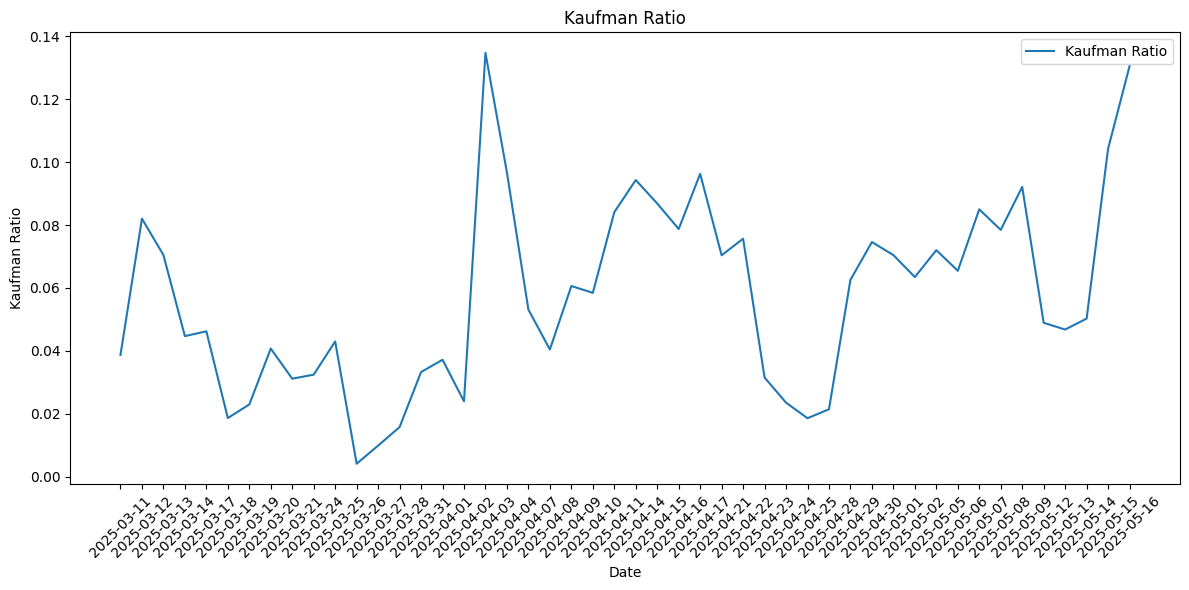

In [ ]:
returns = return_df['Close'].pct_change().dropna()
return_df['Log_Return'] = np.log(return_df['Close'] / return_df['Close'].shift(1))
return_df = return_df.dropna(subset=['Log_Return'])

def kaufman_ratio(prices, window = 100):
    signal = prices.diff(window).abs()
    noise = prices.diff().abs().rolling(window).sum()

    er = signal / noise
    return er

return_df['kaufman'] = kaufman_ratio(return_df['Close'], window=100)
return_df = return_df.dropna(subset=['kaufman'])

#plot return_df['kaufman'])
plt.figure(figsize=(12, 6))
plt.plot(return_df['Date'], return_df['kaufman'], label='Kaufman Ratio')
plt.title('Kaufman Ratio')
plt.xlabel('Date')
plt.ylabel('Kaufman Ratio')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
return_df = return_df.dropna(subset=['kaufman'])
return_df['kaufman'].head()

202    0.038755
203    0.082016
204    0.070474
205    0.044730
206    0.046231
Name: kaufman, dtype: float64

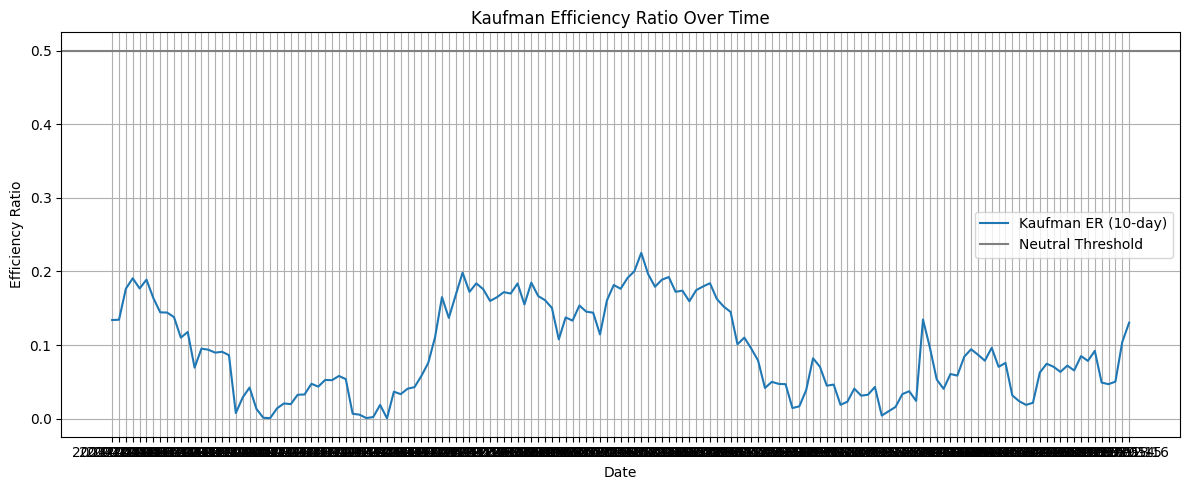

In [5]:
plt.figure(figsize=(12,5))
plt.plot(return_df['Date'], return_df['kaufman'], label='Kaufman ER (10-day)')
plt.axhline(0.5, color='gray', label='Neutral Threshold')
plt.title('Kaufman Efficiency Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('Efficiency Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
series = return_df['Log_Return'].dropna() #initialise series
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(series)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

#hurst exponent calculation , used lag values

def hurst_exponent(ts, max_lag= 150):
    lags = range(2,max_lag)
    
    tau =[np.std(np.subtract(ts[:lags], ts[:-lags])) for lag in lags] #calculating varinace Xt - Xt-1
    
    poly = np.polyfit(log(lags), lag(tau), 1)
    return poly[0]*2.0 #log^2H

ADF Statistic: -12.424686572224896
p-value: 4.0636879124670436e-23
Critical Values: {'1%': -3.4753253063120644, '5%': -2.881274703275226, '10%': -2.5772928360116873}


In [26]:
import numpy as np


def hurst_exponent(ts, max_lag=20):
    lags = range(2, max_lag)
    tau = []
    valid_lags = []

    for lag in lags:
        diff = ts[lag:] - ts[:-lag]
        std = np.std(diff)
        if std > 0 and not np.isnan(std):
            tau.append(std)
            valid_lags.append(lag)

    
    log_lags = np.log(valid_lags)
    log_tau = np.log(tau)

    
        
 

    if len(log_lags) < 2:
        return np.nan  # Not enough data to fit

    poly = np.polyfit(log_lags, log_tau, 1)
    return poly[0] * 2.0
log_ts = np.log(return_df['Close'].dropna().values)
hurst = hurst_exponent(log_ts, max_lag=150)
print("Hurst Exponent:", hurst)


Hurst Exponent: -0.15705524095650605
